**This notebook is just a slight modification of the below notebook**(Hyperparam tuning)


https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79



In [1]:
import warnings

warnings.filterwarnings("ignore")

import os, joblib, gc, pickle
import yaml
import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import seaborn as sns
import catboost as cbt 
import lightgbm as lgb
import matplotlib.pyplot as plt
import ctypes;
libc = ctypes.CDLL('libc.so.6');
from tqdm import tqdm
import holidays
import datetime 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller, coint
import sklearn

import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# Classes

In [2]:
!mkdir models

In [3]:
path_models = '/kaggle/input/models-enefit/'
path_data = '/kaggle/input/dataset-enefit/'

In [4]:
# 18 : 67.48 : base (LB)
# 20 : 67.44 : ffill
# 26 : 66.89 : Diff target 48
# 29 : 67.88 : Erreure (drop mauvaise Features)
# 39 : 65.94 : new fe, no log no perm impt, sans extram temps
# 68 : 66.1  : log + extrems temps                                    : 54.820049280
# 69 : 66.06 : no log + extrems temps                                 : 55.009747
# 70 : 65.88 : log not same name + diff temps only                    : 55.135592
# 73 : 65.89 : log (same name) + diff temps only                      : 55.1068220
# 100: 63.7  : 4 models, 2500, new fes                                : 52.058979
# 101: 63.89 : 4 models, 2500, new fes + drops <-.2                   : 51.692231
# 102: 63.73 : 4 models, 2500, new fes + drops <-.1                   : 51.615020
# 103: 63.71 : 4 models, 2500, new fes + drops <-.2 + new drops       : 51.33366  : 99
# 104: 63.8  : 4 models, 2500, new fes + drops <-.1 + new params      :
# 114: 63.7  : no perm, 4 models,  like 104 + new fes (days)  
# 121: 64.04 : 2lgb, no perm, noog                                    : 52.225582459339364
# 124:       : 1lgb1cbt, no perm, noog                                : 73
# 127: 64.01 : 2lgb, no perm, noog +hours ahead                       : 52.28472321727262
# 130:       : 1lgb,1cbt, no perm, noog, +hours ahead                 : 72
# 131/132 : va : 52.2255 : LB : 64.04 : Base (2models)
# 133/134 : va : 52.1668 : LB : 64.18 : Base + new params
# 135/136 : va : 52.3206 : LB : 64.05 : Base + new drops  
# 135/137 : va : 52.2255 : LB : 64.07 : Base + 2000 estimators  
# 131/146 : va : 52.2255 : LB : Error : Base + oog

In [5]:
n_models = 1
n_estimators = 1
l_ca = ["county", "is_business", "product_type", "is_consumption", 'segment']
device ='cpu'
l_models = ['lgb'] #cbt

log = True
lstm = True

split = True
permutation_importance = False
ongoing_train = False
ffill = True

load_models = False

In [6]:
# LSTM
sequence_length = 10
hidden_size = 32
batch_size = 1024 * 10
num_layers = 3

### DataStorage

In [7]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = ["target","county","is_business","product_type","is_consumption","datetime","row_id",]
    client_cols = ["product_type","county","eic_count","installed_capacity","is_business","date",]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = ["latitude","longitude","hours_ahead","temperature","dewpoint","cloudcover_high","cloudcover_low","cloudcover_mid","cloudcover_total","10_metre_u_wind_component","10_metre_v_wind_component","forecast_datetime","direct_solar_radiation","surface_solar_radiation_downwards","snowfall","total_precipitation",]
    historical_weather_cols = ["datetime","temperature","dewpoint","rain","snowfall","surface_pressure","cloudcover_total","cloudcover_low","cloudcover_mid","cloudcover_high","windspeed_10m","winddirection_10m","shortwave_radiation",    "direct_solar_radiation","diffuse_radiation","latitude","longitude",]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = ["target","county","is_business","product_type","is_consumption","datetime",]

    def __init__(self):
        self.df_data = pl.read_csv(os.path.join(self.root, "train.csv"),columns=self.data_cols,try_parse_dates=True,)
        self.df_client = pl.read_csv(os.path.join(self.root, "client.csv"),columns=self.client_cols,try_parse_dates=True,)
        self.df_gas_prices = pl.read_csv(os.path.join(self.root, "gas_prices.csv"),columns=self.gas_prices_cols,try_parse_dates=True,)
        self.df_electricity_prices = pl.read_csv(os.path.join(self.root, "electricity_prices.csv"),columns=self.electricity_prices_cols,try_parse_dates=True,)
        self.df_forecast_weather = pl.read_csv(os.path.join(self.root, "forecast_weather.csv"),columns=self.forecast_weather_cols,try_parse_dates=True,)
        self.df_historical_weather = pl.read_csv(os.path.join(self.root, "historical_weather.csv"),columns=self.historical_weather_cols,try_parse_dates=True,)
        self.df_weather_station_to_county_mapping = pl.read_csv(os.path.join(self.root, "weather_station_to_county_mapping.csv"),columns=self.location_cols,try_parse_dates=True,)
        self.df_data = self.df_data.filter(pl.col("datetime") >= pd.to_datetime("2022-01-01"))
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (self.df_weather_station_to_county_mapping.with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),))
        self.max_date_data = self.df_data['datetime'].max()

    def update_with_new_data(self,df_new_client,df_new_gas_prices,df_new_electricity_prices,df_new_forecast_weather,df_new_historical_weather,df_new_target,):
        df_new_client = pl.from_pandas(df_new_client[self.client_cols], schema_overrides=self.schema_client)
        df_new_gas_prices = pl.from_pandas(df_new_gas_prices[self.gas_prices_cols],schema_overrides=self.schema_gas_prices,)
        df_new_electricity_prices = pl.from_pandas(df_new_electricity_prices[self.electricity_prices_cols],schema_overrides=self.schema_electricity_prices,)
        df_new_forecast_weather = pl.from_pandas(df_new_forecast_weather[self.forecast_weather_cols],schema_overrides=self.schema_forecast_weather,)
        df_new_historical_weather = pl.from_pandas(df_new_historical_weather[self.historical_weather_cols],schema_overrides=self.schema_historical_weather,)
        df_new_target = pl.from_pandas(df_new_target[self.target_cols], schema_overrides=self.schema_target)

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(["date", "county", "is_business", "product_type"])
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(["forecast_date"])
        self.df_electricity_prices = pl.concat([self.df_electricity_prices, df_new_electricity_prices]).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat([self.df_forecast_weather, df_new_forecast_weather]).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat([self.df_historical_weather, df_new_historical_weather]).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(["datetime", "county", "is_business", "product_type", "is_consumption"])

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(df_test[self.data_cols[1:]], schema_overrides=self.schema_data)
        return df_test
    
    def filter_on_test(self, df_test):
        df_test = df_test.filter(df_test['datetime'] > self.max_date_data)
        return df_test

### FeaturesGenerator

In [8]:
log_feature = ['cloudcover_high_historical_168h', 'cloudcover_mid_historical_local_168h', 'cloudcover_mid_historical_24h', 'snowfall_historical_48h', 'rain_historical_168h', 'cloudcover_high_historical_local_168h', 'temperature_historical_24h', 'windspeed_10m_historical_local_168h', 'cloudcover_total_forecast_local_168h', 'dewpoint_historical_48h', 'cloudcover_high_historical_48h', 'surface_pressure_historical_24h', 'surface_pressure_historical_local_48h', 'cloudcover_mid_forecast_local_168h', 'winddirection_10m_historical_168h', 'cloudcover_low_historical_168h', '10_metre_v_wind_component_forecast_local_0h', 'cloudcover_total_forecast_168h', 'cloudcover_total_historical_168h', 'target_all_county_type_sum_ratio_168_336', 'winddirection_10m_historical_local_168h', 'direct_solar_radiation_historical_24h']

In [9]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
        self.first = True

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.date().alias("mdate"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str("county","is_business","product_type","is_consumption",separator="_",).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date)),
            on=["county", "is_business", "product_type", "date"], how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (datetime.date(row["year"], row["month"], row["day"])in self.estonian_holidays)

    def _holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features
    
    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            #.drop("hours_ahead")
            .with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),)
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (df_forecast_weather.group_by("datetime").mean().drop("county"))

        df_forecast_weather_local = (df_forecast_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean())

        for hours_lag in [0,  2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (self.data_storage.df_weather_station_to_county_mapping)

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (df_target.group_by(["datetime", "county", "is_business", "is_consumption"]).sum().drop("product_type"))
        df_target_all_county_type_sum = (df_target.group_by(["datetime", "is_business", "is_consumption"]).sum().drop("product_type", "county"))

        hours_list=[i*24 for i in range(2,15)]

        for hours_lag in hours_list:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [ f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24] ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(["datetime", "dayofyear", 'mdate', 'literal',
                                        'year', 'log_target_all_county_type_sum_ratio_168_336',
                                        'windspeed_10m_historical_local_48h', 'surface_pressure', 'log_10_metre_v_wind_component_forecast_local_0h', 'cloudcover_high_historical_168h', 
                                        'cloudcover_low_historical_168h', 'temperature_historical_48h', '10_metre_v_wind_component_forecast_168h', '10_metre_u_wind_component_forecast_local_168h', 'winddirection_10m_historical_local_48h', 'log_cloudcover_high_historical_168h', 'cloudcover_high_forecast_local_168h', 'rain_historical_168h', 'surface_pressure_historical_24h', 'log_surface_pressure_historical_local_48h', 'surface_pressure_historical_local_48h', 'log_winddirection_10m_historical_local_168h', 'cloudcover_high_forecast_168h', 'windspeed_10m_historical_local_168h', 'winddirection_10m', 
                                        'cloudcover_low_historical_local_168h', 'log_cloudcover_low_historical_168h', 'cloudcover_total_historical_168h', '10_metre_u_wind_component_forecast_48h', 'snowfall_forecast_168h', 'windspeed_10m', 'total_precipitation_forecast_168h',
                                        'hours_ahead_forecast_168h', 'hours_ahead_forecast_local_168h',
                                       ], axis = 1 , errors='ignore')
#         = 0
#         <-0.2
#         <-0.1
#         <-0.2 New ones.
#         duplicated
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = l_ca

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        #df_features = df_features.drop('segment', axis = 1)
        return df_features
    
    # added some new features here
    def _additional_features(self,df):
        for col in ['temperature', 'dewpoint', '10_metre_u_wind_component', '10_metre_v_wind_component', 'target_48h']:
            for window in [1]:
                df[f"{col}_diff_{window}"] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)

        df['target_48h_m_target_72h'] = df['target_48h'] - df['target_72h']
        df['target_48h_m_target_96h'] = df['target_48h'] - df['target_96h']   
        df['target_48h_m_target_169h'] = df['target_48h'] - df['target_168h']   
        df['target_48h_m_target_336h'] = df['target_48h'] - df['target_336h']    
        df['target_48h_m_target_mean'] = df['target_48h'] - df['target_mean']
        df['accel_1'] = df['target_48h_m_target_72h'] - df['target_48h_m_target_96h']
        df['accel_2'] = df['target_48h_m_target_72h'] - df['target_48h_m_target_mean']
        df['accel_3'] = df['target_48h_m_target_96h'] - df['target_48h_m_target_mean']

        df['z_score_target_48h'] = ((df['target_48h'] - df['target_mean']) / df['target_std']).fillna(0)

        df['mean_target_48h_72h'] = (df['target_48h'] + df['target_72h']) / 2
        df['mean_target_48h_72h_96h'] = (df['target_48h'] + df['target_72h'] + df['target_96h']) / 3

        df['target_48h_m_mean_target_48h_72h'] = df['target_48h'] - df['mean_target_48h_72h']
        df['z_score_1_target_48h'] = ((df['target_48h'] - df['target_48h_m_mean_target_48h_72h']) / df[['target_48h','target_72h']].std(axis = 1)).fillna(0)

        df['target_48h_m_mean_target_48h_72h_96h'] = df['target_48h'] - df['mean_target_48h_72h_96h']
        df['z_score_2_target_48h'] = ((df['target_48h'] - df['target_48h_m_mean_target_48h_72h_96h']) / df[['target_48h','target_72h','target_96h']].std(axis = 1)).fillna(0)

        # va['temperature_historical_24h'].quantile(0.99) = 16.914286
        # tr['temperature_historical_24h'].quantile(0.99) = 21.929464
        #df['extrem_temp'] = (df['temperature_historical_24h'] > 16.914286) * 1
        df['diff_temp'] =  df['temperature_historical_24h'] / df['temperature_historical_48h']
        # va['diff_temp'].quantile(0.99) = 5.3039727
        # tr['diff_temp'].quantile(0.99) = 9.761589
        #df['perc_temp'] = (df['diff_temp'] >5.3039727) * 1
        if log :

            if self.first :
                self.first = False
                self.dic_min ={}
                for col in log_feature[:]:
                    self.dic_min[col] = min(df[col])

            for col in log_feature:
                df[f'log_{col}'] = np.where((df[col] - self.dic_min[col])!= 0, np.log(df[col] - self.dic_min[col]),0)
        df['diff_dsrfl'] =  df['direct_solar_radiation_forecast_local_0h'] / df['direct_solar_radiation_forecast_local_168h']
        df['diff_ssrdfl'] =  df['surface_solar_radiation_downwards_forecast_local_0h'] / df['surface_solar_radiation_downwards_forecast_local_168h']
        df['ratio_target48_ic'] =  df['target_48h'] / df['installed_capacity']

        df['target_48h_mean_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('mean')
        df['target_48h_mean_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('mean')
        ##########################################################################################################
        df['target_48h_min_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('min')
        df['target_48h_min_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('min')
                
        df['target_48h_max_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('max')
        df['target_48h_max_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('max')

        df['target_48h_std_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('std')
        df['target_48h_std_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('std')
        df['target_48h_first_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('first')
        df['target_48h_first_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('first')
        df['target_48h_last_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('last')
        df['target_48h_last_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h"].transform('last')
        df['last_48h_minus_first_48h'] =  df['target_48h_last_day'] - df['target_48h_first_day']
        df['county_last_48h_minus_first_48h'] =  df['target_48h_last_day_county'] / df['target_48h_first_day_county']
        ##########################################################################################################
        df['target_48h_diff_1_mean_day'] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business','year', 'day', 'month'])["target_48h_diff_1"].transform('mean')
        df['target_48h_diff_1_mean_day_county'] = df.groupby(['is_consumption', 'product_type', 'is_business', 'year', 'day', 'month'])["target_48h_diff_1"].transform('mean')
        return df
    
    def _log_outliers(self,df):
        l1=['installed_capacity', 'target_mean', 'target_std']
        for i in l1:
            df = df.with_columns([(f"log_outliers_{i}", pl.when(df[i] != 0).then(np.log(pl.col(i))).otherwise(0))])
        return df
    
    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (df_prediction_items.drop("target"),df_prediction_items.select("target"),)
        else:
            y = None

        df_features = df_prediction_items.with_columns(pl.col("datetime").cast(pl.Date).alias("date"),)

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._holidays_features,
            self._log_outliers,
            self._reduce_memory_usage
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)
        df_features = self._additional_features(df_features)
        df_features = self._drop_columns(df_features)

        return df_features

### Model

In [10]:
def my_mae(pred, target):
    return np.sum(np.abs((pred - target)))/len(target)

In [11]:
def feval_mae(y_pred, lgb_data2):
    y_true = lgb_data2.get_label()
    return 'mae', my_mae(y_pred, y_true), False
    

In [12]:
params_cbt = {'objective' : 'MAE', 
              'random_seed':2023,
              'max_depth': 15, 
              'learning_rate': 0.05,
              'subsample': 0.5, 'colsample_bylevel': 0.5, 
              'min_data_in_leaf': 48,
              "iterations" : n_estimators}

params_lgb = {  "objective": "regression_l1","device": device,
            "n_estimators": n_estimators,"learning_rate": 0.05,"colsample_bytree": 0.8,"colsample_bynode": 0.5,
            "lambda_l1": 3.4,"lambda_l2": 1.4,"max_depth": 15,"num_leaves": 490,"min_data_in_leaf": 48,

        }

model_dict = {
    'lgb': lgb.LGBMRegressor( **params_lgb),
    'cbt': cbt.CatBoostRegressor( **params_cbt)
}    


In [13]:
class Model:
    def __init__(self):
#         self.model_parameters = {  "objective": "regression_l1","device": device,
#             "n_estimators": n_estimators,"learning_rate": 0.05,"colsample_bytree": 0.8,"colsample_bynode": 0.5,
#             "lambda_l1": 3.4,"lambda_l2": 1.4,"max_depth": 15,"num_leaves": 490,"min_data_in_leaf": 48,
#         }
        self.model_parameters = {
                "n_estimators": n_estimators,
                "learning_rate": 0.06,
                "colsample_bytree": 0.9,
                "colsample_bynode": 0.6,
                "lambda_l1": 3.5,
                "lambda_l2": 1.5,
                "max_depth": 16,
                "num_leaves": 500,
                "min_data_in_leaf": 50,
                "device": device,
               "objective" :  'regression_l1'
            }
        self.model_consumption = []
        self.model_production = []
        self.list_models = l_models
        
    def refit(self, df): 
        mask = df_train_features["is_consumption"] == 1
        tr_dataset = lgb.Dataset(df_train_features[mask][l_fe], df_train_features[mask]["target"] - df_train_features[mask]["target_48h"].fillna(0), categorical_feature = l_ca)
        for i in range(0, n_models*2, 2):
            self.model_parameters['seed'] = i
            self.model_parameters['random_seed'] = i
            for modelname in self.list_models : 
                if modelname=='lgb':
                    mask = df["is_consumption"] == 1
                    tr_dataset = lgb.Dataset(df[mask][l_fe], df[mask]["target"] - df[mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )
                    model = lgb.train(params=self.model_parameters, train_set=tr_dataset, init_model = self.model_consumption[i], num_boost_round = 100)
                    self.model_consumption[i] = model
                    
                    mask = df["is_consumption"] == 0
                    tr_dataset = lgb.Dataset(df[mask][l_fe], df[mask]["target"] - df[mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )
                    model = lgb.train(params=self.model_parameters, train_set=tr_dataset, init_model = self.model_production[i], num_boost_round = 100)
                    self.model_production[i] = model
                    
                else:
                    mask = df["is_consumption"] == 1
                    model_dict[modelname].fit(df[mask].drop(columns=["target"]), df[mask]["target"] - df[mask]["target_48h"].fillna(0), init_model = self.model_consumption[i+1], verbose=100, cat_features  = l_ca, num_boost_round = 100)
                    self.model_consumption[i+1] = model_dict[modelname]
                    
                    mask = df["is_consumption"] == 0
                    model_dict[modelname].fit(df[mask].drop(columns=["target"]), df[mask]["target"] - df[mask]["target_48h"].fillna(0), init_model = self.model_consumption[i+1], verbose=100, cat_features  = l_ca, num_boost_round = 100)
                    self.model_production[i+1] = model_dict[modelname]

                
    def fit(self, df_train_features):
        if permutation_importance or split:
            for i in range(n_models):
                self.model_parameters['seed'] = i
                self.model_parameters['random_seed'] = i
                for modelname in self.list_models : 
                    if modelname=='lgb':
                        tr_mask = tr["is_consumption"] == 1
                        va_mask = va["is_consumption"] == 1
                        tr_dataset = lgb.Dataset(tr[tr_mask].drop(columns=["target"]), tr[tr_mask]["target"] - tr[tr_mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )
                        va_dataset = lgb.Dataset(va[va_mask].drop(columns=["target"]), va[va_mask]["target"] - va[va_mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )

                        model = lgb.train(params=self.model_parameters, train_set=tr_dataset, valid_sets=va_dataset, feval = [feval_mae], callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(50, verbose=True)])
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_consumption.append(model)
                        feature_imp =  model.feature_importance()
                        
                        tr_mask = tr["is_consumption"] == 0
                        va_mask = va["is_consumption"] == 0
                        tr_dataset = lgb.Dataset(tr[tr_mask].drop(columns=["target"]), tr[tr_mask]["target"] - tr[tr_mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )
                        va_dataset = lgb.Dataset(va[va_mask].drop(columns=["target"]), va[va_mask]["target"] - va[va_mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )

                        model = lgb.train(params=self.model_parameters, train_set=tr_dataset, valid_sets=va_dataset, feval = [feval_mae], callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(50, verbose=True)])
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_production.append(model)
                        feature_imp = feature_imp + model.feature_importance()
                        
                        feature_imp = pd.DataFrame(list(zip(l_fe,feature_imp)), columns = ['features', 'importance'])
                        feature_imp = feature_imp.sort_values('importance', ascending=True)
                        feature_imp.to_csv(f'models/feature_importance.csv')

                        fig, ax = plt.subplots(figsize=(20, max(10, int(len(feature_imp)/5))))
                        bars = ax.barh(feature_imp['features'], np.round(feature_imp['importance'], 5), height = 0.4,  color='g')
                        ax.bar_label(bars)
                        plt.grid(True)
                        plt.savefig('models/feature_imp.png')
                        plt.show()
                    else:
                        tr_mask = tr["is_consumption"] == 1
                        va_mask = va["is_consumption"] == 1
                        model_dict[modelname].fit(tr[tr_mask].drop(columns=["target"]), tr[tr_mask]["target"] - tr[tr_mask]["target_48h"].fillna(0), 
                                eval_set=[(va[va_mask].drop(columns=["target"]), va[va_mask]["target"] - va[va_mask]["target_48h"].fillna(0))], 
                                verbose=100,  early_stopping_rounds=50, cat_features  = l_ca)
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_consumption.append(model_dict[modelname])
                                                
                        tr_mask = tr["is_consumption"] == 0
                        va_mask = va["is_consumption"] == 0
                        model_dict[modelname].fit(tr[tr_mask].drop(columns=["target"]), tr[tr_mask]["target"] - tr[tr_mask]["target_48h"].fillna(0), 
                                eval_set=[(va[va_mask].drop(columns=["target"]), va[va_mask]["target"] - va[va_mask]["target_48h"].fillna(0))], 
                                verbose=100,  early_stopping_rounds=50, cat_features  = l_ca)
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_production.append(model_dict[modelname])
  
        else :                        
            for i in range(n_models):
                self.model_parameters['seed'] = i
                self.model_parameters['random_seed'] = i
                for modelname in self.list_models : 
                    if modelname=='lgb':
                        print(i, 'lgb')
                        mask = df_train_features["is_consumption"] == 1
                        tr_dataset = lgb.Dataset(df_train_features[mask].drop(columns=["target"]), df_train_features[mask]["target"] - df_train_features[mask]["target_48h"].fillna(0),  categorical_feature = l_ca, free_raw_data=False )
                        model = lgb.train(params=self.model_parameters, train_set=tr_dataset, callbacks=[lgb.callback.log_evaluation(period=100)])
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_consumption.append(model)
                        
                        mask = df_train_features["is_consumption"] == 0
                        tr_dataset = lgb.Dataset(df_train_features[mask].drop(columns=["target"]), df_train_features[mask]["target"] - df_train_features[mask]["target_48h"].fillna(0), categorical_feature = l_ca, free_raw_data=False )
                        model = lgb.train(params=self.model_parameters, train_set=tr_dataset, callbacks=[lgb.callback.log_evaluation(period=100)])
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_production.append(model)
                    else:
                        print(i, 'cbt')
                        mask = df_train_features["is_consumption"] == 1
                        model_dict[modelname].fit(df_train_features[mask].drop(columns=["target"]), df_train_features[mask]["target"] - df_train_features[mask]["target_48h"].fillna(0), verbose=100, cat_features  = l_ca)
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_consumption.append(model_dict[modelname])
                        
                        mask = df_train_features["is_consumption"] == 0
                        model_dict[modelname].fit(df_train_features[mask].drop(columns=["target"]), df_train_features[mask]["target"] - df_train_features[mask]["target_48h"].fillna(0), verbose=100, cat_features  = l_ca)
                        joblib.dump(model, f'models/{modelname}_{i}.model')
                        self.model_production.append(model_dict[modelname])


    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(df_features[mask]["target_48h"].fillna(0).values + np.nanmean([x.predict(df_features[mask]) for x in self.model_consumption],0), 0, np.inf)

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(df_features[mask]["target_48h"].fillna(0).values + np.nanmean([x.predict(df_features[mask]) for x in self.model_production],0), 0, np.inf)
                                           
        return predictions


# Initialisation & Feature Generation

In [14]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [15]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]
df_train_features = df_train_features.drop(["date", "hour"], axis = 1 , errors='ignore')

In [16]:
l_fe = list(df_train_features.drop(columns=["target"]).columns)
print(len(l_fe), l_fe)
yaml.dump(l_fe, open('models/l_fe', 'w'))

227 ['county', 'is_business', 'product_type', 'is_consumption', 'day', 'weekday', 'month', 'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)', 'eic_count', 'installed_capacity', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation', 'hours_ahead_forecast_local_0h', 'temperature_forecast_local_0h', 'dewpoint_forecast_local_0h', 'cloudcover_high_forecast_local_0h', 'cloudcover_low_forecast_local_0h', 'cloudcover_mid_forecast_local_0h', 'cloudcover_total_forecast_local_0h', '10_metre_u_wind_component_forecast_local_0h', '10_metre_v_wind_component_forecast_local_0h', 'direct_solar_radiation_forecast_local_0h', 'surface_solar_radiation_downwards_forecast_local_0h', 'snowfall_forecast_local_0h', 'total_precipitation_forecast_local_0h', 'hours_ahead_forecast

In [17]:
l_ca_lstm = ['county','is_business','product_type','is_consumption']
l_fe_lstm = [x for x in l_fe if x not in ['segment']]
print(len(l_fe), len(l_fe_lstm))
yaml.dump(l_fe_lstm, open('models/l_fe_lstm', 'w'))

227 226


In [18]:
if False :
    df_train_features['nt'] = target = (df_train_features["target"] - df_train_features["target_48h"].fillna(0)).values
    df_train_features['date'] = df_train_features.apply(lambda row: datetime.date(row['year'], row['month'], row['day']), axis=1)
    df_train_features['ms'] = df_train_features['is_business'].astype(str) + df_train_features['product_type'].astype(str) + df_train_features['is_consumption'].astype(str)
    df_train_features.head()
    
    l_fe = list(df_train_features.drop(columns=["target"]).columns)
    print(len(l_fe), l_fe)

In [19]:
if ffill :
    l_fet = list(df_train_features.drop(columns=["county", "is_business", "product_type", 'is_consumption', "target"]).columns)

    df_train_features[l_fet] = df_train_features.groupby(["county", "is_business", "product_type", 'is_consumption'])[l_fet].ffill()
    df_train_features[l_fet] = df_train_features.groupby(["county", "is_business", "product_type", 'is_consumption'])[l_fet].bfill()
    
    dic_ffill_all_col = df_train_features.drop_duplicates(["county", "is_business", "product_type", 'is_consumption'], keep = 'last').set_index(["county", "is_business", "product_type", 'is_consumption'])[l_fet].to_dict()

In [20]:
df_train_features = df_train_features.reset_index(drop = True)

l_date_id = list(df_train_features.index)
train_index = l_date_id[:int(len(l_date_id)*0.9)]
test_index = l_date_id[int(len(l_date_id)*0.9):]

print((len(train_index), len(test_index)))

tr = df_train_features.iloc[train_index].reset_index(drop=True).copy()
va = df_train_features.iloc[test_index].reset_index(drop=True).copy()   

def duplicateColumns(data):
    dupliCols=[]
    for i in range(0,len(data.columns)):
        col1=data.columns[i]
        for col2 in data.columns[i+1:]:
            if data[col1].equals(data[col2]):
                dupliCols.append(col1+','+col2)
    return dupliCols

duplCols=duplicateColumns(va)
print(duplCols)

(1486711, 165191)
[]


In [21]:
class lstm_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, sequence_length = sequence_length):
        self.sequence_length = sequence_length
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
        return x, self.Y[i]
    
class by_category_lstm_Dataset(torch.utils.data.Dataset):
    def __init__(self, 
                 X : np.ndarray, 
                 Y : np.ndarray,  
                 l_ca : list, 
                 l_fe : list, 
                 sequence_length = sequence_length):
        
        self.sequence_length = sequence_length
        self.l_cat = l_ca
        self.l_fe = l_fe
        self.l_fe_col_idx_minus_cat = [i[0] for i in enumerate(l_fe) if i[1] not in l_ca]
        self.l_cat_col_idx = [i[0] for i in enumerate(l_fe) if i[1] in l_ca]
        
        #### INT for Categorical var (for pytorch)
        self.cat = torch.tensor(X[:, self.l_cat_col_idx].astype(int))
        self.idx = torch.tensor(np.arange(0, len(self.cat)))
        self.fes = torch.tensor(X[:, self.l_fe_col_idx_minus_cat].astype(float)).float()
        self.Y = torch.tensor(Y).float()
        
    def __len__(self):
        return self.cat.shape[0]
    
    def __getitem__(self, i):
        fes_get = self.fes[(self.idx <= i) & (self.cat == self.cat[i]).all(axis=1)]
        cat_get = self.cat[(self.idx <= i) & (self.cat == self.cat[i]).all(axis=1)]
        size =  len(cat_get)
        if size >= sequence_length - 1:
            i_start = size - sequence_length + 1
            fes_get = fes_get[i_start:(i + 1), :]
            cat_get = cat_get[i_start:(i + 1), :]

        else:
            padding = fes_get[0].repeat(self.sequence_length - size - 1, 1)
            fes_get = fes_get[0:(i + 1), :]
            fes_get = torch.cat((padding, fes_get), 0)
            
            padding = cat_get[0].repeat(self.sequence_length - size - 1, 1)
            cat_get = cat_get[0:(i + 1), :]
            cat_get = torch.cat((padding, cat_get), 0)
        return torch.cat((cat_get, fes_get), 1), self.Y[i]
    

In [22]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [23]:
def tr_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
    num_batches = len(dataloader)
    total_loss  = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss  += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break
        if shortcut > 0 and batch == shortcut:
            num_batches = shortcut
            break 
    avg_loss = total_loss / num_batches
    return total_loss#avg_loss

def va_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
        scheduler.step(total_loss)
    avg_loss = total_loss / num_batches
    return total_loss#avg_loss
        
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output.detach().cpu().numpy().flatten()

In [24]:
class condLSTM(torch.nn.Module):
    def __init__(self,
                 l_ca : list, 
                 l_fe : list,
                 hidden_size=hidden_size, 
                 output_size=1, 
                 num_layers= num_layers, 
                 bidir = True,
                 Verbose = True
                ):
        super().__init__()
        self.Verbose = Verbose 
        self.l_ca_size = len(l_ca)
        self.l_fe_minus_cat_size = len([i[1] for i in enumerate(l_fe) if i[1] not in l_ca])
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size 
        
        self.mult_bidir = 2 if bidir else 1
        self.cond_c = torch.nn.Linear(in_features = self.l_ca_size, out_features = self.hidden_size * self.num_layers * self.mult_bidir)
        self.cond_h = torch.nn.Linear(in_features = self.l_ca_size, out_features = self.hidden_size * self.num_layers * self.mult_bidir)
        self.lstm = torch.nn.LSTM(input_size = self.l_fe_minus_cat_size, 
                                  hidden_size = self.hidden_size, num_layers = self.num_layers, bidirectional  = bidir,
                                  dropout=0.05, batch_first=True)
        self.linear1 = torch.nn.Linear(in_features = self.hidden_size * self.mult_bidir, 
                                       out_features=int(hidden_size/2) * self.mult_bidir)
        self.linear2 = torch.nn.Linear(in_features=int(hidden_size/2) * self.mult_bidir, out_features=1)

    def forward(self, x):        
        if self.Verbose : print(f'x : {x.shape}')
        if self.Verbose : print(f'x[:, 0, :self.cat_size ] : {x[:, 0, :self.l_ca_size ].shape}')
        cat_c = self.cond_c(x[:, 0, :self.l_ca_size])
        cat_h = self.cond_h(x[:, 0, :self.l_ca_size])
        c0 = torch.reshape(cat_c, (self.num_layers * self.mult_bidir, -1, self.hidden_size))
        h0 = torch.reshape(cat_h, (self.num_layers * self.mult_bidir, -1, self.hidden_size))
        #h0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        #c0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        #torch.nn.init.xavier_normal_(h0)
        #torch.nn.init.xavier_normal_(c0)
        # Xavier/Glorot Initialization: for Activation => None, hyperbolic Tan (tanh), Logistic(sigmoid), softmax.
        # He Initialization: for Activation => Rectified Linear activation unit(ReLU) and Variants.
        # LeCun Initialization: for Activation => Scaled Exponential Linear Unit(SELU)
        if self.Verbose :print(f'c0 : {c0.shape}')
        if self.Verbose :print(f'h0 : {h0.shape}')

        x, (hn, _) = self.lstm(x[:, :, self.l_ca_size:], (h0, c0))
        if self.Verbose : print(f'x after lstm : {x.shape}')
        if self.Verbose : print(f'hn after lstm : {hn.shape}')
        x = x[:, -1, :]
        if self.Verbose : print(f'x after filter : {x.shape}')
        x = self.linear1(x)
        if self.Verbose : print(f'x after linear1 : {x.shape}')
        x = self.linear2(x)
        if self.Verbose : print(f'x after linear2 : {x.shape}'); self.Verbose = False
        return x


In [25]:
if lstm :
    torch.manual_seed(2023)
    model = condLSTM(l_ca_lstm, l_fe_lstm).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
    early_stopper = EarlyStopper(patience=10, min_delta=0.0001)
    loss_fn = torch.nn.L1Loss()


    tr_np = tr[l_fe_lstm].replace([np.inf, -np.inf], np.nan).fillna(0)
    va_np = va[l_fe_lstm].replace([np.inf, -np.inf], np.nan).fillna(0)
    mms = sklearn.preprocessing.MinMaxScaler()
    mms.fit(tr_np)
    tr_np = mms.transform(tr_np)
    va_np = mms.transform(va_np)
    joblib.dump(mms, f'models/MinMaxScaler.l_fe')

    tr_y_np = tr['target'].values
    va_y_np = va['target'].values
    mmst = sklearn.preprocessing.MinMaxScaler()
    mmst.fit(np.array(tr_y_np).reshape(-1, 1))

    tr_y_np = mmst.transform(np.array(tr_y_np).reshape(-1, 1))
    va_y_np = mmst.transform(np.array(va_y_np).reshape(-1, 1))
    joblib.dump(mmst, f'models/MinMaxScaler.target')


    tr_py = by_category_lstm_Dataset(tr_np, tr_y_np, l_ca_lstm, l_fe_lstm)
    va_py = by_category_lstm_Dataset(va_np, va_y_np, l_ca_lstm, l_fe_lstm)

    tr_dataloader = torch.utils.data.DataLoader(tr_py, batch_size=batch_size, shuffle=False)
    va_dataloader = torch.utils.data.DataLoader(va_py, batch_size=batch_size, shuffle=False)

    libc.malloc_trim(0)
    gc.collect()

    history = pd.DataFrame([], columns=["epoch", "train_loss", "test_loss", "lr"])
    for epoch in range(n_estimators):
        tr_loss = tr_loop(tr_dataloader, model, loss_fn, optimizer, shortcut=1)                 
        va_loss = va_loop(va_dataloader, model, loss_fn)
        print(f"Epoch {epoch+1:>3d}, Train : {tr_loss:>5f}, Valid : {va_loss:>5f}")
        if early_stopper.early_stop(va_loss, model):  
            model = early_stopper.get_best_model()
            break
        history.loc[len(history),:] = [epoch+1, tr_loss, va_loss, optimizer.param_groups[0]['lr']]

    joblib.dump(model, f'models/model.lstm.jolib')
    torch.save(model.state_dict(), f'models/model.state_dict')
    torch.save(model, 'models/model.full')
    pred = predict(va_dataloader, model)     
    pred = mmst.inverse_transform(pred.reshape(-1, 1)).ravel()
    mae_score = np.sum(np.abs((pred - va['target'].values)))/len(va['target'].values)
    print(f'val mae {mae_score}')

x : torch.Size([10240, 9, 226])
x[:, 0, :self.cat_size ] : torch.Size([10240, 4])
c0 : torch.Size([6, 10240, 32])
h0 : torch.Size([6, 10240, 32])
x after lstm : torch.Size([10240, 9, 64])
hn after lstm : torch.Size([6, 10240, 32])
x after filter : torch.Size([10240, 64])
x after linear1 : torch.Size([10240, 32])
x after linear2 : torch.Size([10240, 1])
Epoch   1, Train : 0.272452, Valid : 1.618275
val mae 1469.0118274439799


In [26]:

class LSTM(torch.nn.Module):
    def __init__(self, input_size=len(l_fe), hidden_size=hidden_size, output_size=1, num_layers= num_layers, bidir = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size 
        self.test = True
        self.mult_bidir = 2 if bidir else 1
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers , dropout=0.05, batch_first=True, bidirectional  = bidir)
        self.linear1 = torch.nn.Linear(in_features =hidden_size * self.mult_bidir, out_features=int(hidden_size/2) * self.mult_bidir)
        self.linear2 = torch.nn.Linear(in_features=int(hidden_size/2) * self.mult_bidir, out_features=1)

    def forward(self, x):
        if self.test : print(f'x : {x.shape}')
        h0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        torch.nn.init.xavier_normal_(h0)
        torch.nn.init.xavier_normal_(c0)
        if self.test :print(f'h0 : {h0.shape}')
        if self.test :print(f'c0 : {c0.shape}')
        x, (hn, _) = self.lstm(x, (h0, c0))
        if self.test : print(f'x after lstm : {x.shape}')
        if self.test : print(f'hn after lstm : {hn.shape}')
        x = x[:, -1, :]
        if self.test : print(f'x after filter : {x.shape}')
        x = self.linear1(x)
        if self.test : print(f'x after linear1 : {x.shape}')
        x = self.linear2(x)
        if self.test : print(f'x after linear2 : {x.shape}'); self.test = False
        return x

class LSTMwithAttention(torch.nn.Module):
    def __init__(self, input_size=len(l_fe), hidden_size=hidden_size, output_size=1, num_layers= num_layers, bidir = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size 
        self.test = True
        self.mult_bidir = 2 if bidir else 1
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers , dropout=0.05, batch_first=True, bidirectional  = bidir)
        self.attn = torch.nn.MultiheadAttention(embed_dim=hidden_size * self.mult_bidir, num_heads=5)
        self.linear1 = torch.nn.Linear(in_features=hidden_size * self.mult_bidir, out_features=int(hidden_size/2) * self.mult_bidir)
        self.linear2 = torch.nn.Linear(in_features=int(hidden_size/2) * self.mult_bidir, out_features=1)

    def forward(self, x):
        if self.test : print(f'x : {x.shape}')
        h0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        torch.nn.init.xavier_normal_(h0)
        torch.nn.init.xavier_normal_(c0)
        if self.test :print(f'h0 : {h0.shape}')
        if self.test :print(f'c0 : {c0.shape}')
        x, (hn, _) = self.lstm(x, (h0, c0))
        if self.test : print(f'x after lstm : {x.shape}')
        if self.test : print(f'hn after lstm : {hn.shape}')
        if self.mult_bidir == 2:
            hn = torch.cat((hn[-1,:, :], hn[-2,:, :]),1)
        else :
            hn = hn[-1,:, :]
        if self.test : print(f'hn after filter : {hn.shape}')
        x, weight = self.attn(hn, hn, hn)
        if self.test : print(f'x after attn : {x.shape}')
        x = self.linear1(x)
        if self.test : print(f'x after linear1 : {x.shape}')
        x = self.linear2(x)
        if self.test : print(f'x after linear2 : {x.shape}'); self.test = False
        return x
    
class convLSTMwithAttention(torch.nn.Module):
    def __init__(self, input_size=len(l_fe), hidden_size=hidden_size, output_size=1, num_layers= num_layers, bidir = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size 
        self.test = True
        
        self.conv1d = torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_size, padding =2, kernel_size=5)
        #self.conv1d = torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=1)
        self.mult_bidir = 2 if bidir else 1
        self.lstm = torch.nn.LSTM(input_size = hidden_size, hidden_size = hidden_size, num_layers = num_layers , dropout=0.05, batch_first=True, bidirectional  = bidir)
        self.attn = torch.nn.MultiheadAttention(embed_dim=hidden_size * self.mult_bidir, num_heads=5)
        self.linear1 = torch.nn.Linear(in_features=hidden_size * self.mult_bidir, out_features=int(hidden_size/2) * self.mult_bidir)
        self.linear2 = torch.nn.Linear(in_features=int(hidden_size/2) * self.mult_bidir, out_features=1)

    def forward(self, x):
        if self.test : print(f'x : {x.shape}')
        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        x = x.transpose(1, 2) 
        if self.test :print(f'x after transpose 1 : {x.shape}')
        x = self.conv1d(x)    
        if self.test :print(f'x after conv1d : {x.shape}')
        #Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for LSTM
        x = x.transpose(1, 2)
        if self.test :print(f'x after transpose 2 : {x.shape}')

        h0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers * self.mult_bidir, x.shape[0], self.hidden_size).requires_grad_()
        torch.nn.init.xavier_normal_(h0)
        torch.nn.init.xavier_normal_(c0)
        if self.test :print(f'h0 : {h0.shape}')
        if self.test :print(f'c0 : {c0.shape}')
        x, (hn, _) = self.lstm(x, (h0, c0))
        if self.test : print(f'x after lstm : {x.shape}')
        if self.test : print(f'hn after lstm : {hn.shape}')
        if self.mult_bidir == 2:
            hn = torch.cat((hn[-1,:, :], hn[-2,:, :]),1)
        else :
            hn = hn[-1,:, :]
        if self.test : print(f'hn after filter : {hn.shape}')
        x, weight = self.attn(hn, hn, hn)
        if self.test : print(f'x after attn : {x.shape}')
        x = self.linear1(x)
        if self.test : print(f'x after linear1 : {x.shape}')
        x = self.linear2(x)
        if self.test : print(f'x after linear2 : {x.shape}'); self.test = False
        return x 

# Train Model

In [27]:
libc.malloc_trim(0)
gc.collect()

0

[LightGBM] [Warning] seed is set=0, random_seed=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] seed is set=0, random_seed=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.369103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53896
[LightGBM] [Info] Number of data points in the train set: 743355, number of used features: 226
[LightGBM] [Warning] seed is set=0, random_seed=0 will be ignored. Current value: seed=0
[LightGBM] [Info] Start training from score -0.103000
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 113.44	valid_0's mae: 113.44
[LightGBM] [Warning] seed is set=0, random_seed=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] seed is set=0, random_seed=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] Auto-choosing col-wise multi-

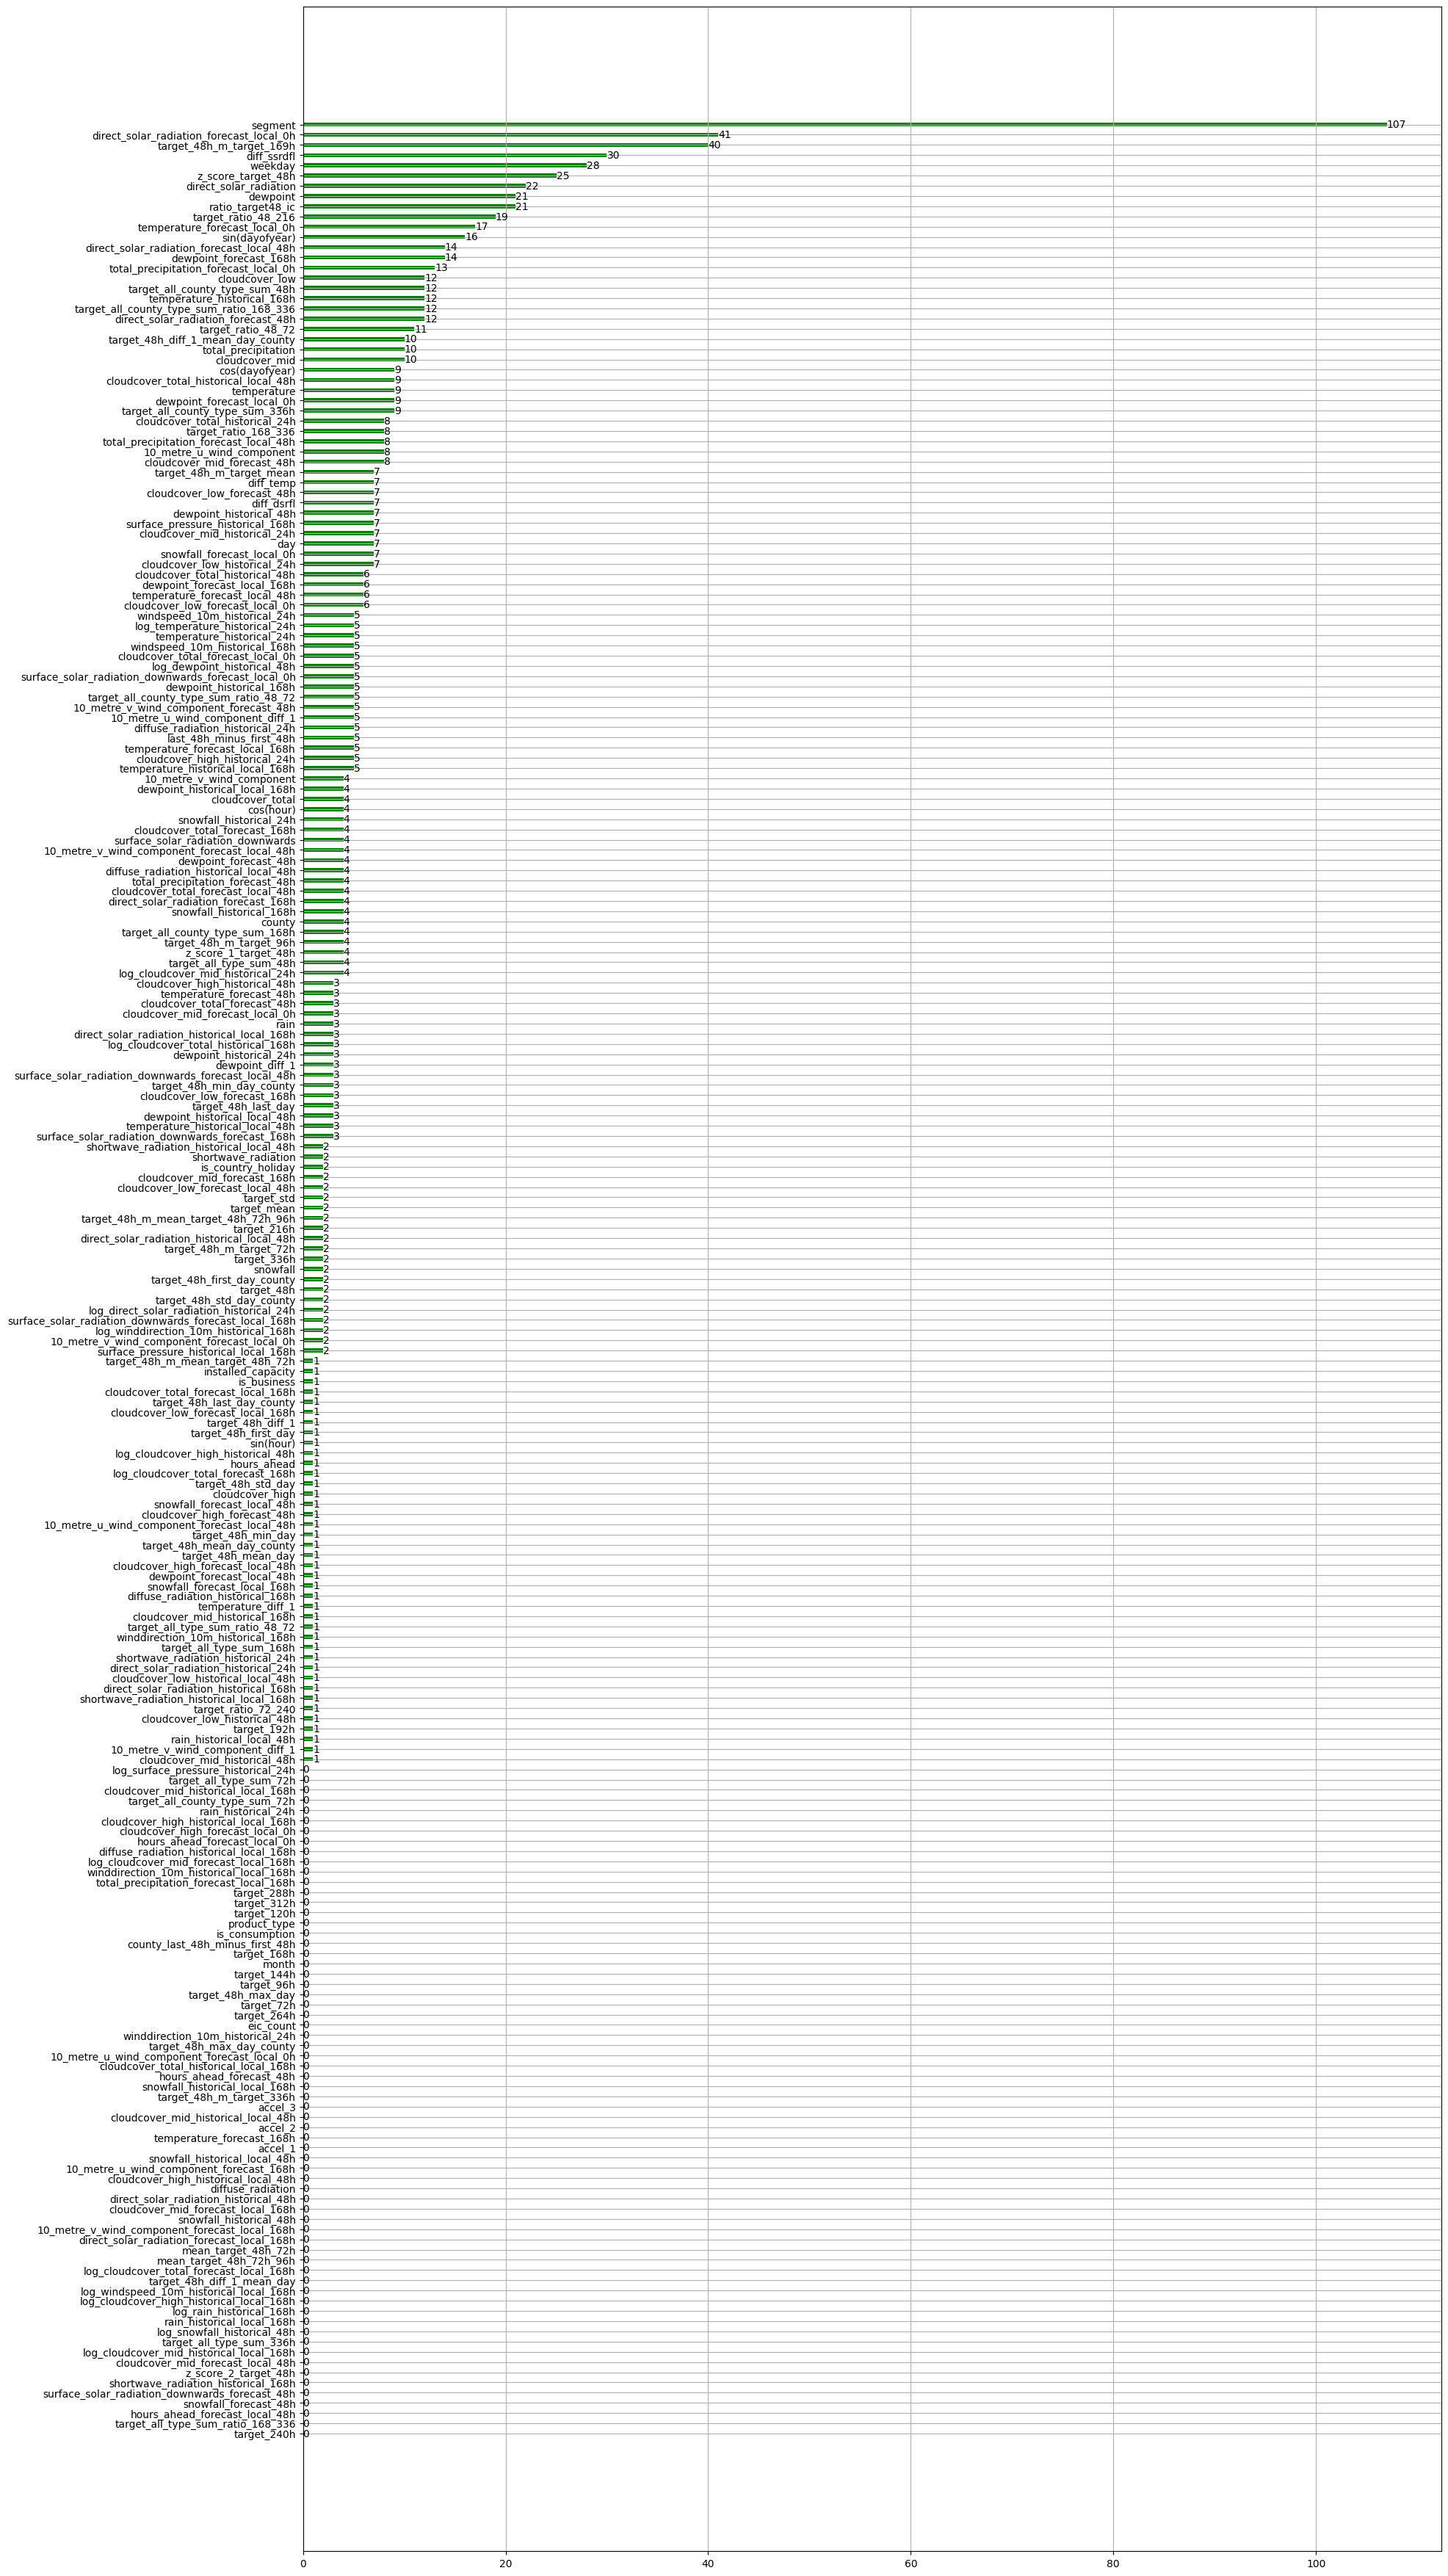

43986

In [28]:
model = Model()
model.fit(df_train_features)

libc.malloc_trim(0)
gc.collect()

In [29]:
if not (split or permutation_importance):
    va = df_train_features.copy()

pred = model.predict(va[l_fe])
target = va['target'].values 
    
va['error'] = target - pred
va['pred'] = pred
va['error2'] = va['error'].abs()
print(va['error2'].mean() , va['error2'].max())
    
mae_score = np.sum(np.abs((pred  - target)))/len(pred)
print(f'val mae {mae_score}')

115.0820711538136 10541.917965240478
val mae 115.0820711538136


In [30]:
def adf_test(serie, verbose = False):
    result = adfuller(serie)
    p_val_adf = result[1]
    if (p_val_adf > 0.05) :
        if verbose : print(f'ADF test has a pvalue of {p_val_adf} (more than 0.05), serie is not stationary.')
        return False
    else :
        if verbose : print(f'ADF test has a pvalue of {p_val_adf} (less than 0.05), serie is stationary.')
        return True

In [31]:
# df_train_features['ms'] = df_train_features['county'].astype(str) + df_train_features['is_business'].astype(str) + df_train_features['product_type'].astype(str) + df_train_features['is_consumption'].astype(str)
# l = []
# for fe in [x for x in l_fe if x not in l_ca] :
#     confs = list(df_train_features['ms'].unique())
#     libc.malloc_trim(0)
#     gc.collect()
#     try :
#         for conf in confs : 
#                 s = df_train_features[df_train_features['ms'] == conf][fe].dropna().values
#                 if not adf_test(s) :
#         #             print(f'{fe}, serie is not stationary.')
#                     l.append(fe)
#     except :
#         print(f'error {fe}')
    
# print(list(set(l)))

In [32]:
print(np.sum(np.abs((np.round(pred, 2) - target)))/len(target))

115.08206813930542


In [33]:
print(np.sum(np.abs((pred - target)))/len(target))

115.0820711538136


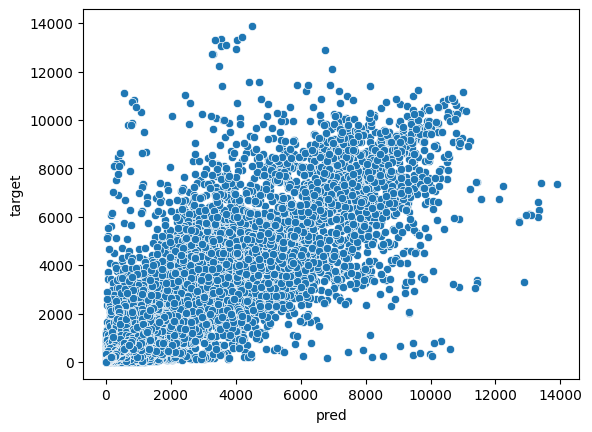

error                                   1.000000
target_48h_m_target_169h                0.659072
target_48h_m_target_336h                0.606012
target_48h_m_target_mean                0.479061
target_48h_m_target_96h                 0.408052
target_48h_m_mean_target_48h_72h_96h    0.404579
target_48h_m_target_72h                 0.309497
target_48h_m_mean_target_48h_72h        0.309497
target                                  0.231721
accel_3                                 0.224005
accel_1                                 0.208858
target_48h                              0.196325
z_score_target_48h                      0.151727
mean_target_48h_72h                     0.146195
ratio_target48_ic                       0.144862
Name: error, dtype: float64

target                     1.000000
target_168h                0.931084
target_mean                0.925826
mean_target_48h_72h_96h    0.920166
target_192h                0.916724
target_144h                0.916029
mean_target_48h_72h        0.915376
target_336h                0.909916
target_48h                 0.908350
target_312h                0.899975
target_72h                 0.895759
target_120h                0.893142
target_96h                 0.889956
target_216h                0.888452
target_288h                0.880579
Name: target, dtype: float64

In [34]:
if True:
    sns.scatterplot(va, x = 'pred', y = 'target')
    plt.show()
    corr_error = va[l_fe + ['error', 'target']].corr()
    display(corr_error['error'].abs().nlargest(15))
    display(corr_error['target'].abs().nlargest(15))

,county,is_business,product_type,is_consumption,day,weekday,month,segment,sin(dayofyear),cos(dayofyear),...,target_48h_first_day_county,target_48h_last_day,target_48h_last_day_county,last_48h_minus_first_48h,county_last_48h_minus_first_48h,target_48h_diff_1_mean_day,target_48h_diff_1_mean_day_county,error,pred,error2
1028,0,1,3,1,10,1,4,0_1_3_1,0.989372,-0.145404,...,7251.125000,7154.727051,215.296005,-96.397949,0.029691,-7.132202e+00,-1.349715,4116.957175,5146.406825,4116.957175
1116,11,1,3,1,10,1,4,11_1_3_1,0.989372,-0.145404,...,7251.125000,4210.918945,215.296005,-127.768066,0.029691,-7.847453e+00,-1.349715,3215.130474,3478.200526,3215.130474
1158,0,1,3,1,10,1,4,0_1_3_1,0.989372,-0.145404,...,7251.125000,7154.727051,215.296005,-96.397949,0.029691,-7.132202e+00,-1.349715,3790.279480,4140.919520,3790.279480
4018,0,1,3,1,11,2,4,0_1_3_1,0.986731,-0.162366,...,6929.903809,7317.828125,212.835999,387.924316,0.030713,6.795878e+00,1.895126,3382.407140,5789.092860,3382.407140
4106,11,1,3,1,11,2,4,11_1_3_1,0.986731,-0.162366,...,6929.903809,4894.308105,212.835999,749.811035,0.030713,2.847455e+01,1.895126,3448.810435,3689.240565,3448.810435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160905,0,0,3,0,30,2,5,0_0_3_0,0.536696,-0.843776,...,15.918000,33.750999,9.143000,17.833000,0.574381,4.138840e-01,0.032405,6349.201932,3639.521068,6349.201932
160913,0,1,3,0,30,2,5,0_1_3_0,0.536696,-0.843776,...,5.849000,10.933000,0.000000,5.084000,0.000000,1.930072e-01,-0.057048,3894.591909,2897.770091,3894.591909
161000,11,1,3,1,30,2,5,11_1_3_1,0.536696,-0.843776,...,6497.691895,4475.330078,161.649994,1321.557129,0.024878,5.441317e+01,3.830230,3477.714389,1743.087611,3477.714389
161035,0,0,3,0,30,2,5,0_0_3_0,0.536696,-0.843776,...,15.918000,33.750999,9.143000,17.833000,0.574381,4.138840e-01,0.032405,3180.719766,5225.685234,3180.719766


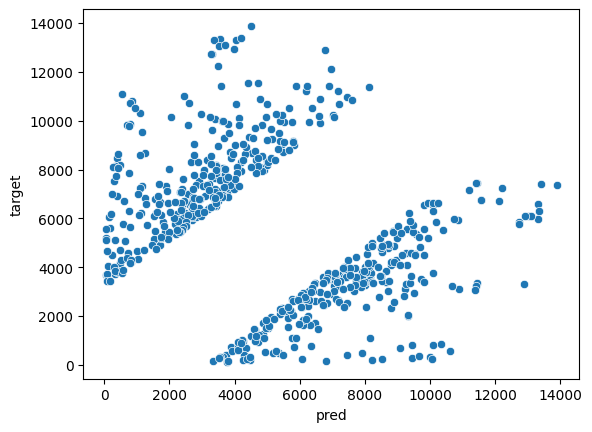

error                                   1.000000
target_48h_m_target_336h                0.839086
target_all_type_sum_48h                 0.806136
target_48h                              0.804622
target_48h_m_target_169h                0.800949
target                                  0.795432
ratio_target48_ic                       0.775745
target_all_county_type_sum_48h          0.770161
mean_target_48h_72h                     0.730035
target_48h_m_target_mean                0.674895
target_48h_max_day_county               0.665126
target_48h_m_target_96h                 0.652233
mean_target_48h_72h_96h                 0.614670
target_48h_m_mean_target_48h_72h_96h    0.613995
target_48h_max_day                      0.606235
Name: error, dtype: float64

target                             1.000000
error                              0.795432
target_48h_m_target_336h           0.602400
target_336h                        0.600697
target_all_type_sum_336h           0.592934
target_48h_m_target_169h           0.502610
target_all_county_type_sum_336h    0.499697
target_168h                        0.468022
target_144h                        0.462366
target_all_type_sum_168h           0.455354
target_all_county_type_sum_48h     0.434222
target_std                         0.428317
target_312h                        0.422336
ratio_target48_ic                  0.413022
target_all_county_type_sum_72h     0.372173
Name: target, dtype: float64

In [35]:
if True:
    limit = 3090 #va['error2'].mean()
    display(va[va['error2']> limit])
    sns.scatterplot(va[va['error2']> limit], x = 'pred', y = 'target')
    plt.show()
    corr_error = va[va['error2']> limit][l_fe + ['error', 'target']].corr()
    display(corr_error['error'].abs().nlargest(15))
    display(corr_error['target'].abs().nlargest(15))

In [36]:
if permutation_importance :        
    libc.malloc_trim(0);
    gc.collect();

    l_perm = l_fe
    l_perm = list(set(l_perm) - set(l_ca))
    gc.collect()
    results = {}
    size = len(pred)
    
    for feature in tqdm(l_ca):
        save_col = va[feature].copy()
        va[feature] = np.random.permutation(va[feature])
        va[feature] = va[feature].astype("category")
        pred = model.predict(va[l_fe])
        results[feature] = np.sum(np.abs((pred  - target)))/size - mae_score
        va[feature] = save_col 
    
    for feature in tqdm(l_perm):
        save_col = va[feature].copy()
        va[feature] = np.random.permutation(va[feature])
        pred = model.predict(va[l_fe])
        results[feature] = np.sum(np.abs((pred  - target)))/size - mae_score
        va[feature] = save_col 
    
        
    df_perm_impt = pd.DataFrame.from_dict(results, orient='index', columns=['perm_importance'])
    df_perm_impt = df_perm_impt.sort_values('perm_importance', ascending=True)
    df_perm_impt.to_csv('models/df_perm_impt.csv')

    l_fe_pos_perm = list(df_perm_impt[df_perm_impt.perm_importance > 0].index)
    print(f'list {len(l_fe_pos_perm)} features with positives permutation importance :  \n{l_fe_pos_perm}')

    l_fe_0_perm = list(df_perm_impt[df_perm_impt.perm_importance == 0].index)
    print(f'list {len(l_fe_0_perm)} features with 0 permutation importance :\n{l_fe_0_perm}')

    l_fe_neg_perm = list(df_perm_impt[df_perm_impt.perm_importance < 0].index)
    print(f'list {len(l_fe_neg_perm)} features with negative permutation importance :\n{l_fe_neg_perm}')

    abv_zero = df_perm_impt[df_perm_impt.perm_importance > 0]
    bel_zero = df_perm_impt[df_perm_impt.perm_importance <= 0]

    fig, ax = plt.subplots(figsize=(20, max(10, int(len(l_perm)/5))))
    bars = ax.barh(bel_zero.index, np.round(bel_zero.perm_importance, 5), height = 0.4, color='r')
    ax.bar_label(bars)
    bars = ax.barh(abv_zero.index, np.round(abv_zero.perm_importance, 5), height = 0.4,  color='g')
    ax.bar_label(bars)

    plt.grid(True)
    plt.savefig('models/perm_impt.png')
    plt.show()
    del abv_zero, bel_zero

In [37]:
del va, df_train_features

# load_models

In [38]:
if load_models :
    models = []
    for dirname, _, filenames in os.walk(path_models):
        for filename in filenames:
            models.append(joblib.load(os.path.join(dirname, filename)))

# Submit API

In [39]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [40]:
iteration = 0
l=[]
max_iter = 30

In [41]:
libc.malloc_trim(0)
gc.collect()

3819

In [42]:
for (df_test, df_new_target, df_new_client, df_new_historical_weather, df_new_forecast_weather, df_new_electricity_prices, df_new_gas_prices, df_sample_prediction) in iter_test:
    iteration += 1 

    data_storage.update_with_new_data(df_new_client=df_new_client, df_new_gas_prices=df_new_gas_prices, df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather, df_new_historical_weather=df_new_historical_weather, df_new_target=df_new_target )
    df_test = data_storage.preprocess_test(df_test)

    if iteration <= max_iter :    
        l.append(df_test)
    if iteration == max_iter and ongoing_train:
        df_t = pl.concat(l)
        #         df_t = data_storage.filter_on_test(df_t)    
        df_test_features = features_generator.generate_features(df_t)
        df_target = df_test_features[['date', 'target_48h', 'hour',"county","is_business","product_type","is_consumption"]].copy()
        df_target['date'] = df_target['date'] - pd.Timedelta(hours= 48)
        df_target = df_target.rename(columns={'target_48h':'target'})
        df_test_features = df_test_features.merge(df_target, on=['date', 'hour',"county","is_business","product_type","is_consumption"], how='left')
        df_test_features = df_test_features[df_test_features['target'].notnull()]
        df_test_features = df_test_features[df_test_features.date > data_storage.max_date_data]
        
        model.refit(df_test_features)
        ongoing_train = False
        
    df_test_features = features_generator.generate_features(df_test)
    
    if ffill:
        for col in l_fet :
            df_test_features['temp'] = df_test_features.set_index(["county", "is_business", "product_type", 'is_consumption']).index.map(dic_ffill_all_col[col])
            df_test_features[col] = df_test_features[col].fillna(df_test_features['temp'])
            dic_2 = df_test_features.drop_duplicates(["county", "is_business", "product_type", 'is_consumption'], keep = 'last').set_index(["county", "is_business", "product_type", 'is_consumption'])[col].to_dict()
            dic_ffill_all_col[col] = {**dic_ffill_all_col[col], **dic_2}
        #df_test_features = df_test_features.drop('temp', axis = 1)
    
    missing_feats = [x for x in l_fe if x not in df_test_features]
    if len(missing_feats) > 0 :
        df_test_features = pd.concat([df_test_features, pd.DataFrame(np.nan, index=np.arange(len(df_test_features)), columns=missing_feats)  ], axis=1)
        
    df_test_features["pred"] = model.predict(df_test_features[l_fe])

    df_sample_prediction["target"] = df_test_features['pred'].values
    env.predict(df_sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
